# 종합실습2 : 제조 공정간 불량 예측



## pulp-and-paper mill 공정
* 비즈니스 상황
    * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 이상 발생
    * 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실
    * 이를 사전에 감지하는 것은 굉장히 어려운 일입니다. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감 효과가 예상됩니다.

* Data
    * 행
        * 주어진 데이터에는 15일 동안 수집된 약 18,000개의 행의 시계열 데이터
        * 데이터는 2분 간격으로 측정.
    * 열 
        * y : normal – 0, abnormal - 1 (124건, 약 0.6%)
            * y 의 abnormal 데이터는 장애 발생 2~4분 전으로 시점에 대한 조정(shift)이 된(전처리 된) 데이터 입니다.
        * x1 - x61: 원자재, 부자재 및 공정 센서 값들로 구성됨.

* 장애 예방 조치
    * 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있습니다.
    * 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.


![](https://keralakaumudi.com/web-news/en/2020/04/NMAN0141956/image/paper-mill.1.582102.jpg)

## 0.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.backend import clear_session

### 2) 데이터셋 불러오기

In [2]:
# 공정 데이터 불러오기
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/processminer2.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


### 3) 필요 함수들 생성

### 0.2 필요 함수들 생성

#### ① reconstruction error plot

* input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [3]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)
    
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [4]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('thresholds')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [63]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))
    
    return confusion_matrix(y, pred_temp)

## 1.데이터 탐색

In [6]:
target = 'y'

* Target 변수의 class 비율을 확인해 봅시다.

In [7]:
print(data[target].value_counts())
print(data[target].value_counts() / data.shape[0])


0.0    18150
1.0      124
Name: y, dtype: int64
0.0    0.993214
1.0    0.006786
Name: y, dtype: float64


## 2.데이터 준비

### 2.2 추가변수

In [8]:
for v in data.columns[2:] :
    var = v + '_diff'
    data[var] = data[v] - data[v].shift()

data.dropna(axis = 0, inplace = True)

### 2.1 x, y로 분할하기

* 불필요한 변수 제거

In [9]:
data.drop('time', axis = 1, inplace = True)

In [10]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### 2.3 데이터 분할
* data ==> train : val = 7 : 3
* stratify=y : y의 class 비율을 유지하면서 분할하기

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state=2022, stratify=y)

In [12]:
y_train.value_counts()/len(y_train)

0.0    0.993198
1.0    0.006802
Name: y, dtype: float64

In [13]:
y_val.value_counts()/len(y_val)

0.0    0.993251
1.0    0.006749
Name: y, dtype: float64

In [14]:
y_val.value_counts()

0.0    5445
1.0      37
Name: y, dtype: int64

### 2.4 스케일링

In [15]:
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### 2.5 학습용 데이터 만들기
Normal 데이터만 사용합니다.

In [16]:
x_train0 = x_train_s[y_train == 0]

x_train0.shape

(12704, 118)

## 3.모델링 : One Class SVM


In [17]:
from sklearn.svm import OneClassSVM

### 3.1 기본 모델링

* default로 모델을 생성하고
* 예측하고
* 평가합니다.

In [19]:
model = OneClassSVM()

model.fit(x_train0)

OneClassSVM()

In [24]:
pred = model.predict(x_val_s)
pred

array([ 1, -1,  1, ..., -1,  1, -1], dtype=int64)

In [25]:
pred = np.where(pred == 1, 0, 1)

In [26]:
print(f'F1 Score: {f1_score(y_val, pred)}')

F1 Score: 0.014684287812041117


### 3.2 nu 값 최적화

* nu 값을 조정하며 튜닝을 합시다.
* for loop를 이용해야 합니다.

* nu 값을 0.001 ~ 1사이에서 조금씩 조정하며 20개 값으로 실험해 봅시다.

In [27]:
nu_param = np.linspace(0.001, 1, 20)
f1 = []

for nu in nu_param :
    model = OneClassSVM(nu=nu)
    model.fit(x_train0)
    
    pred= model.predict(x_val_s)
    pred = np.where(pred==1, 0, 1)
    
    f1.append(f1_score(y_val, pred))

* f1 값이 최대화 될 때의 nu 값을 뽑아 봅시다.

In [28]:
f1_max_nu = nu_param[np.argmax(f1)]
f1_max_nu

0.05357894736842105

* 이제 차트를 그려서 추세를 분석해 봅시다.

nu : 0.05357894736842105, F1 Score : 0.026402640264026403


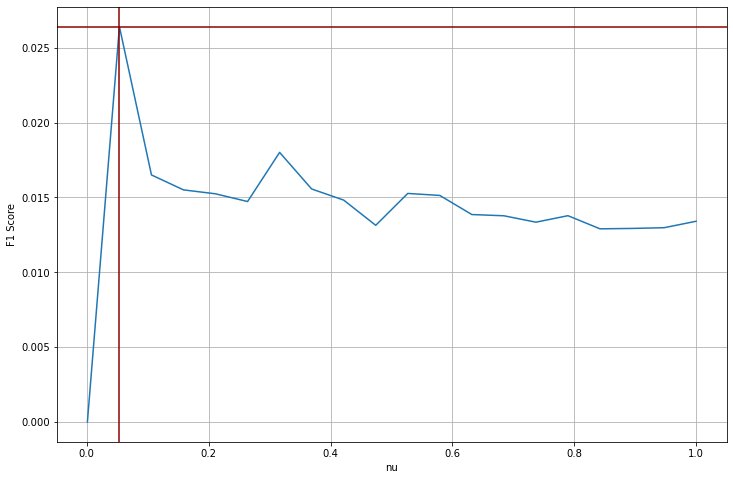

In [29]:
print(f'nu : {f1_max_nu}, F1 Score : {max(f1)}')

plt.figure(figsize=(12,8))
plt.plot(nu_param, f1)

plt.axvline(f1_max_nu, color='darkred')
plt.axhline(max(f1), color='darkred')

plt.xlabel('nu')
plt.ylabel('F1 Score')

plt.grid()
plt.show()

* 최적의 nu 값으로 다시 모델링 합시다.

In [30]:
model = OneClassSVM(nu=f1_max_nu)
model.fit(x_train0)

OneClassSVM(nu=0.05357894736842105)

In [67]:
pred = model.predict(x_val_s)
pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [68]:
pred = np.where(pred == 1, 0, 1)

In [69]:
cm_1csvm = confusion_matrix(y_val, pred)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[5183  262]
 [  33    4]]
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      5445
         1.0       0.02      0.11      0.03        37

    accuracy                           0.95      5482
   macro avg       0.50      0.53      0.50      5482
weighted avg       0.99      0.95      0.97      5482



## 4.모델링 : AE

### 4.1 모델 설계

* 간단한 hyper parameter 설정

In [37]:
epoch = 50
input_dim = x_train.shape[1]
input_dim

118

* 모델 설계

In [39]:
clear_session()

input_layer = Input(shape=(input_dim,))

# Encoder
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(4, activation='relu')(encoder)
encoder = Dense(2, activation='relu')(encoder)

# Decoder
decoder = Dense(4, activation='relu')(encoder)
decoder = Dense(16, activation='relu')(decoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(input_layer, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 118)]             0         
                                                                 
 dense (Dense)               (None, 64)                7616      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
 dense_4 (Dense)             (None, 4)                 12        
                                                                 
 dense_5 (Dense)             (None, 16)                80    

* compile + 학습
    * 학습시 x=x_train0, y=x_train0를 입력합니다. (비지도)

In [44]:
autoencoder.compile(loss='mse', optimizer='adam')

history = autoencoder.fit(x_train0, x_train0, epochs=epoch, validation_data=(x_val_s, x_val_s)).history

Epoch 1/50
397/397 [==============================] - 2s 3ms/step - loss: 0.0259 - accuracy: 0.7576 - val_loss: 0.0260 - val_accuracy: 0.7216
Epoch 2/50
397/397 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.7365 - val_loss: 0.0260 - val_accuracy: 0.6370
Epoch 3/50
397/397 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.7472 - val_loss: 0.0259 - val_accuracy: 0.8251
Epoch 4/50
397/397 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.7258 - val_loss: 0.0259 - val_accuracy: 0.5934
Epoch 5/50
397/397 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.7251 - val_loss: 0.0259 - val_accuracy: 0.5928
Epoch 6/50
397/397 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.7321 - val_loss: 0.0259 - val_accuracy: 0.8179
Epoch 7/50
397/397 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.7405 - val_loss: 0.0259 - val_accuracy: 0.5275
Epoch 

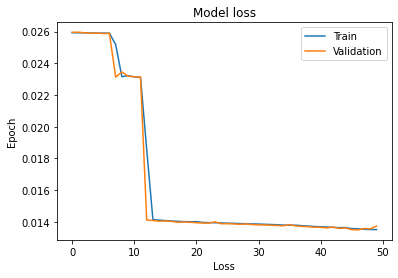

In [45]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')

plt.title('Model loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()

### 4.2 예측 및 Reconstruction Error 계산

* 예측

In [50]:
pred = autoencoder.predict(x_val_s)

In [51]:
pred.shape

(5482, 118)

* 재구성 에러 계산

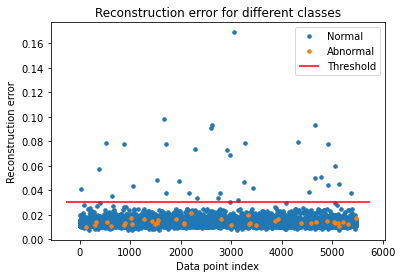

In [52]:
result = recon_err_plot(x_val_s, pred, y_val, .03)

* threshold 값을 조정하면서 precision, recall, f1 을 구해봅시다.

In [53]:
result.head()

,index,Reconstruction_error,True_class
0,6721,0.012549,0.0
1,12921,0.010905,0.0
2,3301,0.012186,0.0
3,12277,0.010772,0.0
4,17679,0.010568,0.0


* f1 값을 최대화 시키는 threshold 값

<ipython-input-4-157f97b4948b>:6: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


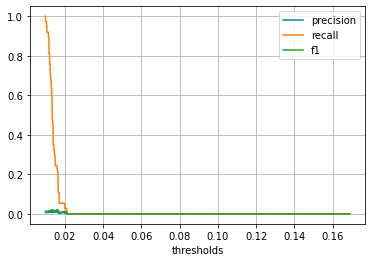

In [54]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

In [56]:
threshold = thresholds[np.argmax(f1)]
threshold

0.015990980680606986

In [64]:
cm_ae = classification_report2(result['True_class'], result['Reconstruction_error'],threshold)

< confusion matrix >

[[4679  766]
 [  29    8]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      5445
         1.0       0.01      0.22      0.02        37

    accuracy                           0.85      5482
   macro avg       0.50      0.54      0.47      5482
weighted avg       0.99      0.85      0.92      5482



## 5.비즈니스 관점의 모델 평가

f1 score가 아닌 비용을 모델을 평가해 봅니다.

* 비즈니스 상황
    * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 이상 발생
    * 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실
    * 이를 사전에 감지하는 것은 굉장히 어려운 일입니다. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감 효과가 예상됩니다.

* 장애 예방 조치
    * 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있습니다.
    * 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.

* 비즈니스 기대가치 매트릭스 만들기

In [60]:
bv = np.array(([0, -3], [-100, -3]))
bv

array([[   0,   -3],
       [-100,   -3]])

* 비용계산

In [71]:
cm1_p = cm_ae / np.sum(cm_ae)

In [72]:
cm2_p = cm_1csvm / np.sum(cm_1csvm)

In [73]:
print(np.sum(bv * cm1_p))
print(np.sum(bv * cm2_p))

-0.9525720539948924
-0.7475373951112733
